In [1]:
library(Seurat)
library(dplyr)
library(magrittr)
IRdisplay::display_html("<style> .container { width:95% !important; } </style>")
library("ggplot2")
library("xlsx")

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
LHb.integrated<-readRDS(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/LHb_integrated_0.8.rds")

In [4]:
cntl<-readRDS("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/cntl_0.8.rds")
stim<-readRDS("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/stim_0.8.rds")

# assgin clusters to cell types

In [5]:
new.ident <- c("MHb1","MHb2","MHb3","LHb1","LHb2","LHb3","MHb4","LHb4","MHb5","LHb5","LHb6","MHb6","Surr1","Surr2","Surr3","Surr4")
names(x = new.ident) <- levels(x =LHb.integrated)
LHb.integrated<- RenameIdents(object =LHb.integrated, new.ident)

In [6]:
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(LHb.integrated@assays$RNA@data[,which(Idents(object=LHb.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
assign(paste(new.ident[i],"_barcode_cntl",sep=""),intersect(colnames(cntl@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_stim",sep=""),intersect(colnames(stim@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))}

In [7]:
LHb.integrated<-subset(x=LHb.integrated,cells=c(MHb1_barcode,MHb2_barcode,MHb3_barcode,LHb1_barcode,LHb2_barcode,LHb3_barcode,MHb4_barcode,MHb5_barcode,LHb4_barcode,LHb5_barcode,MHb6_barcode,LHb6_barcode))

# analyzing all IEGs


# MHb

In [8]:
# used https://www.sciencedirect.com/science/article/pii/S0092867419310712
IEG<-read.xlsx("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/IEG.xlsx",sheetIndex=1)
IEG<-as.character(IEG[[1]])
IEG<-intersect(IEG,rownames(LHb.integrated@assays$RNA@data))

In [9]:
Cell_type<-c("MHb1","MHb2","MHb3","MHb4","MHb5","MHb6")
# make a data frame for cell number (this data frame is a simple version giving single value for each cluster) 
Cell_number<- data.frame("type" =c(rep("MHb1",length(IEG)),rep("MHb2",length(IEG)),rep("MHb3",length(IEG)),rep("MHb4",length(IEG)),rep("MHb5",length(IEG)),rep("MHb6",length(IEG))), "gene" = rep(IEG,6))

E_p<-vector(mode="numeric", length=0) # expression level p value
E_change<-vector(mode="numeric", length=0) # Expression level change

for (i in 1:dim(Cell_number)[1]){
    c_sum<-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0)
    s_sum<-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0)
    temp_c<-LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))][LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0]
    temp_s<-LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))][LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0]
    if(c_sum>0 & s_sum>0){
        res <-wilcox.test(temp_c, temp_s, alternative = "two.sided")
        if(length(Cell_type)*res$p.value>1){E_p[i]<- -log(1)}
        else{E_p[i]<- -log(length(Cell_type)*res$p.value)}
    }else if(c_sum==0 | s_sum==0){E_p[i]<- -log(1)}
}
Cell_number$E_p<-E_p
for (i in 1:dim(Cell_number)[1]){if(sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0)==0 & sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0)==0)
{E_change[i]<-0}else if(sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0)==0){E_change[i]<-0-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))])/sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0)}
   else if(sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0)==0){E_change[i]<-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))])/sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0)}
    else{E_change[i]<-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))])/sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0)-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))])/sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0)}}
Cell_number$E_change<-E_change


Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message 

heatmap

In [10]:
MHb<-subset(Cell_number,type=="MHb1"|type=="MHb2"|type=="MHb3"|type=="MHb4"|type=="MHb5"|type=="MHb6")
MHb$type<-factor(MHb$type,levels=rev(c("MHb1","MHb2","MHb3","MHb4","MHb5","MHb6")))
E_change_p<-numeric()
for(i in 1:dim(MHb)[1]){
    if(MHb$E_p[i]> -log(0.05)){E_change_p[i]<-MHb$E_change[i]}else{E_change_p[i]<- 0}
}
MHb$E_change_p<-E_change_p
MHb<-subset(MHb,gene=="Arc"|gene=="Fosb"|gene=="Fos"|gene=="Junb"|gene=="Jund"|gene=="Egr1"|gene=="Homer1"|gene=="Nr4a2")

In [11]:
library(scales)

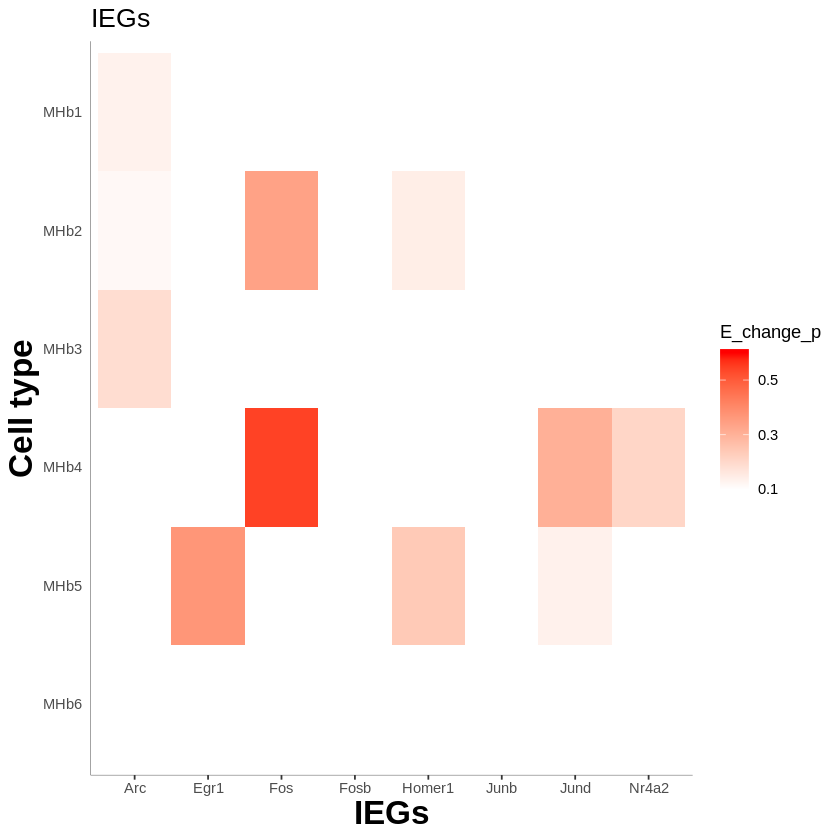

In [12]:
p <-ggplot(MHb, aes(gene,type, fill= E_change_p)) + 
  geom_tile() + scale_fill_gradient(limits=c(0.1, 0.6), breaks=seq(0.1,0.6,by=0.2),low = "white",high = "red", oob=squish)
pp<-p+ylab("Cell type")+xlab("IEGs")+theme(axis.title=element_text(size=20,face="bold"),plot.title = element_text(size=16),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black", size = 0.1),axis.ticks.y = element_blank())+ggtitle("IEGs")
pp
#ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/IEG heatmap MHb2.pdf",width=10,height=5)

Warning message:
“Removed 15 rows containing missing values (geom_point).”Warning message:
“Removed 15 rows containing missing values (geom_point).”

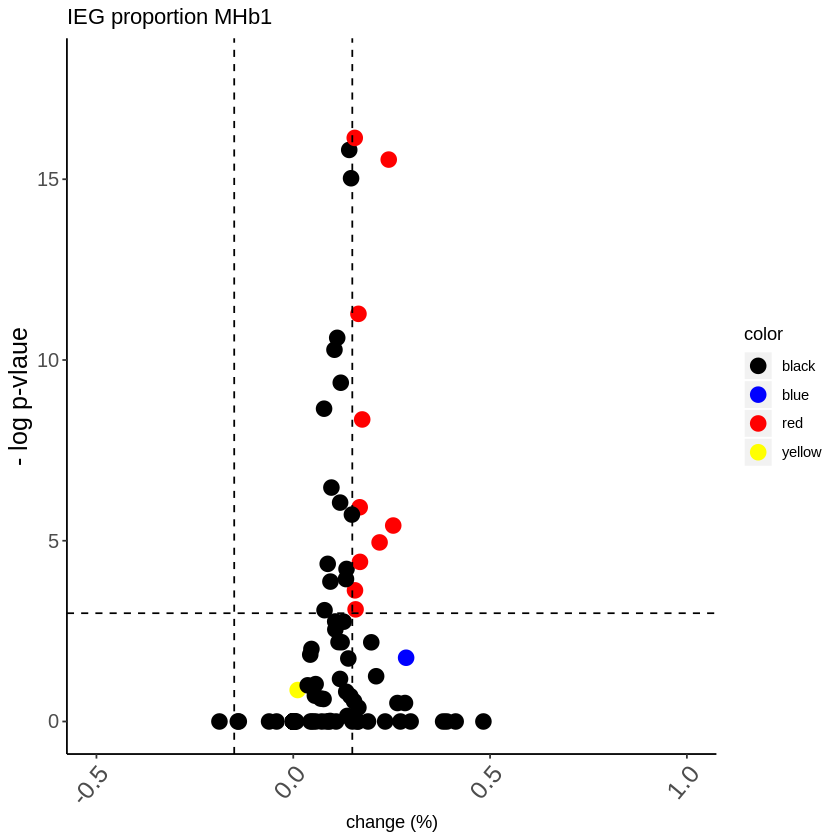

In [10]:
#MHb1, expression
color<- vector(mode="numeric", length=0)
MHb<- subset(Cell_number,type=="MHb1")
for(i in 1:dim(MHb)[1]){
    
    if(MHb$gene[i]=="Fos"){color[i]<-"yellow"}
    else if(MHb$gene[i]=="Egr1"){color[i]<-"blue"}      
     else if (MHb$E_p[i] > -log(0.05) & MHb$E_change[i]>0.15 ){color[i]<- "red"}
    else{color[i]<-"black"}
}
MHb$color<-color

ggplot(MHb,aes(x=E_change,y=E_p,color=color))+geom_point(size=4)+ylab("- log p-vlaue")+xlab("change (%)")+scale_color_manual(values=c("black","blue","red","yellow"))+theme(axis.text.x=element_text(size=10,angle = 50, hjust = 1))+ggtitle("IEG proportion MHb1")+
theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=12),axis.text.x=element_text(size=15,angle = 50, hjust = 1),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+xlim(-0.5,1)+ylim(0,18)+ geom_hline(yintercept=-log(0.05), linetype="dashed", color = "black")+ geom_vline(xintercept =c(-0.15,0.15), linetype="dashed",color = "black")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/MHb1_Expression_level_supple6_0.15_test.pdf",width=10,height=10) # may use +scale_fill_manual(values=c("grey", "black"))
write.xlsx2(MHb,file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/MHb1_Expression_level_supple6_axis.xlsx")

In [29]:
MHb

,type,gene,P_change,P_p,E_p,E_change,color
129,MHb2,Fos,2.49733516,0.0000000,5.1734978,0.34056693,red
130,MHb2,Fosb,-0.38640171,0.0000000,-0.3923930,-0.14054065,black
131,MHb2,Fosl1,0.25125628,0.0000000,0.0000000,1.47563658,black
132,MHb2,Fosl2,-0.25506319,0.0000000,-1.3862944,0.22734248,black
133,MHb2,Jun,4.38366073,2.5460034,-0.2483728,0.03645498,black
134,MHb2,Junb,1.75118014,0.0000000,-1.4398750,-0.05633340,black
135,MHb2,Jund,-8.37330592,1.6554300,5.8722091,0.07432942,black
136,MHb2,Egr1,0.73473428,0.0000000,0.6279802,0.13035000,blue
137,MHb2,Egr2,0.00000000,0.0000000,0.0000000,0.00000000,black
138,MHb2,Egr4,0.25125628,0.0000000,0.0000000,1.30103111,black


Warning message:
“Removed 15 rows containing missing values (geom_point).”

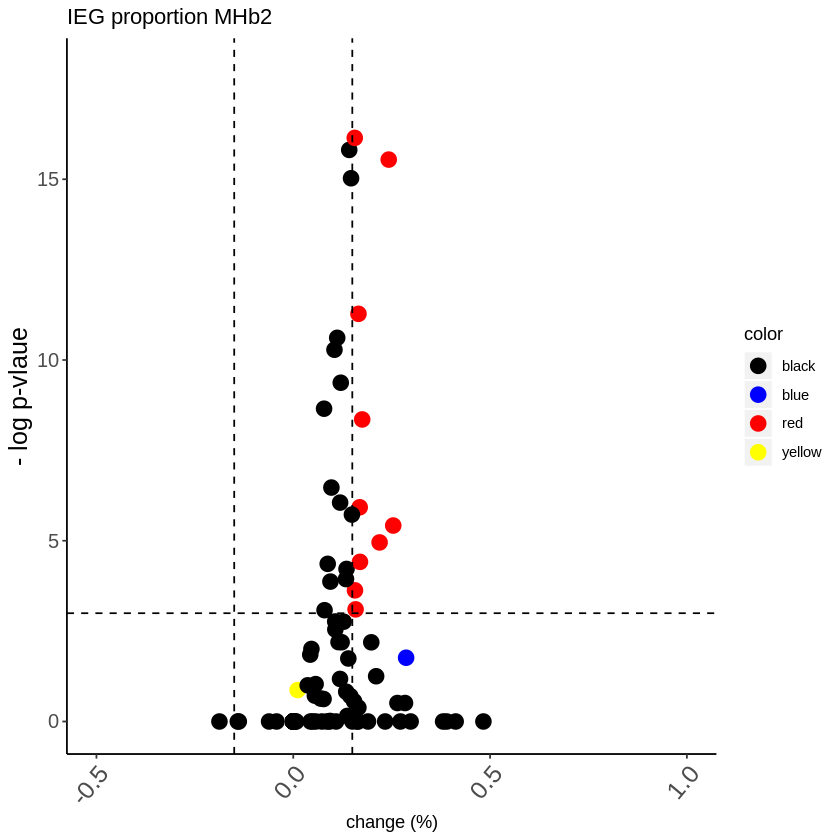

In [13]:
#MHb2, expression, repeat for others
color<- vector(mode="numeric", length=0)
MHb<- subset(Cell_number,type=="MHb2")
for(i in 1:dim(MHb)[1]){
    
    if(MHb$gene[i]=="Fos"){color[i]<-"yellow"}

    else if(MHb$gene[i]=="Egr1"){color[i]<-"blue"}      
     else if (MHb$E_p[i] > -log(0.05) & MHb$E_change[i]>0.15 ){color[i]<- "red"}
    else{color[i]<-"black"}
}
MHb$color<-color

ggplot(MHb,aes(x=E_change,y=E_p,color=color))+geom_point(size=4)+ylab("- log p-vlaue")+xlab("change (%)")+scale_color_manual(values=c("black","blue","red","yellow"))+theme(axis.text.x=element_text(size=10,angle = 50, hjust = 1))+ggtitle("IEG proportion MHb2")+
theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=12),axis.text.x=element_text(size=15,angle = 50, hjust = 1),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+xlim(-0.5,1)+ylim(0,18)+geom_hline(yintercept=-log(0.05), linetype="dashed", color = "black")+ geom_vline(xintercept =c(-0.15,0.15), linetype="dashed",color = "black")
#ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/MHb2_Expression_level_supple6_0.15_testaxis.pdf",width=10,height=10) # may use +scale_fill_manual(values=c("grey", "black"))
#write.xlsx2(MHb,file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/MHb2_Expression_level_supple6.xlsx")

# LHb

In [14]:
IEG<-read.xlsx("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/IEG.xlsx",sheetIndex=1)
IEG<-as.character(IEG[[1]])
IEG<-intersect(IEG,rownames(LHb.integrated@assays$RNA@data))

In [15]:
#create df, p value is -log
Cell_type<-c("LHb1","LHb2","LHb3","LHb4","LHb5","LHb6")
# make a data frame for cell number (this data frame is a simple version giving single value for each cluster) 
Cell_number<- data.frame("type" =c(rep("LHb1",length(IEG)),rep("LHb2",length(IEG)),rep("LHb3",length(IEG)),rep("LHb4",length(IEG)),rep("LHb5",length(IEG)),rep("LHb6",length(IEG))), "gene" = rep(IEG,6))


E_p<-vector(mode="numeric", length=0) # expression level p value
E_change<-vector(mode="numeric", length=0) # Expression level change

    
for (i in 1:dim(Cell_number)[1]){
    c_sum<-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0)
    s_sum<-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0)
    temp_c<-LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))][LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0]
    temp_s<-LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))][LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0]
   if(c_sum>0 & s_sum>0){
        res <-wilcox.test(temp_c, temp_s, alternative = "two.sided")
        if(length(Cell_type)*res$p.value>1){E_p[i]<- -log(1)}
        else{E_p[i]<- -log(length(Cell_type)*res$p.value)}
    }else if(c_sum==0 | s_sum==0){E_p[i]<- -log(1)}
}
Cell_number$E_p<-E_p
for (i in 1:dim(Cell_number)[1]){if(sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0)==0 & sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0)==0)
{E_change[i]<-0}else if(sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0)==0){E_change[i]<-0-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))])/sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0)}
   else if(sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0)==0){E_change[i]<-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))])/sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0)}
    else{E_change[i]<-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))])/sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_stim",sep="")))]>0)-sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))])/sum(LHb.integrated@assays$RNA@data[Cell_number$gene[i],eval(parse(text = paste(Cell_number$type[i],"_barcode_cntl",sep="")))]>0)}}
Cell_number$E_change<-E_change


Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(temp_c, temp_s, alternative = "two.sided"):
“cannot compute exact p-value with ties”Warning message 

In [16]:
LHb<-subset(Cell_number,type=="LHb1"|type=="LHb2"|type=="LHb3"|type=="LHb4"|type=="LHb5"|type=="LHb6")
LHb$type<-factor(LHb$type,levels=rev(c( "LHb1","LHb2","LHb3","LHb4","LHb5","LHb6")))
E_change_p<-numeric()
for(i in 1:dim(LHb)[1]){
    if(LHb$E_p[i]> -log(0.05)){E_change_p[i]<-LHb$E_change[i]}else{E_change_p[i]<- 0}
}
LHb$E_change_p<-E_change_p
LHb<-subset(LHb,gene=="Arc"|gene=="Fosb"|gene=="Fos"|gene=="Junb"|gene=="Jund"|gene=="Egr1"|gene=="Homer1"|gene=="Nr4a2")

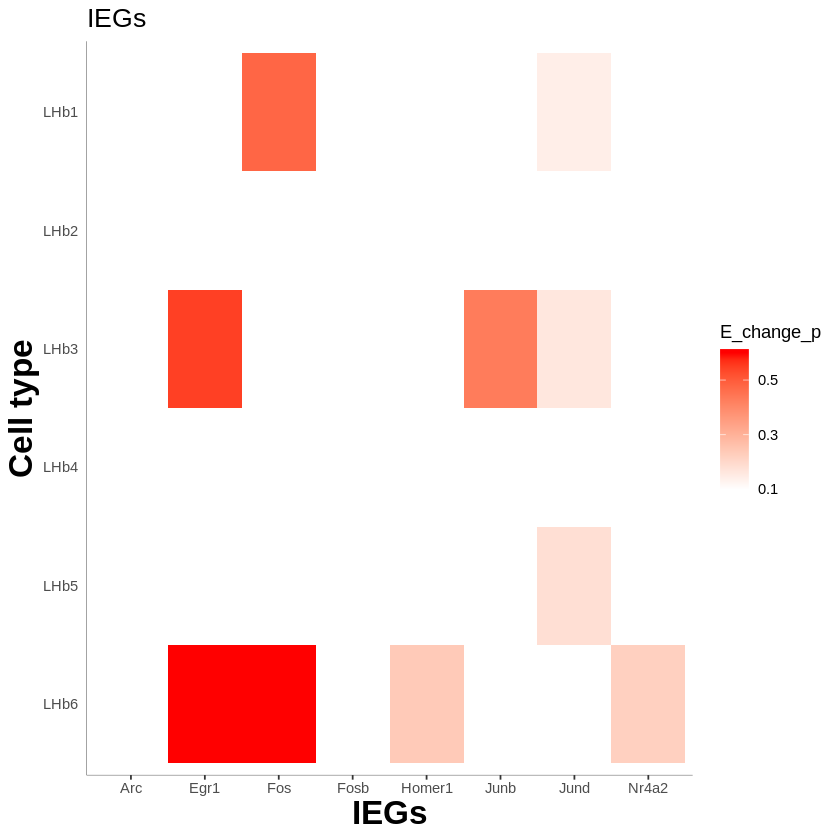

In [17]:
p <-ggplot(LHb, aes(gene,type, fill= E_change_p)) + 
 
  geom_tile() + scale_fill_gradient(limits=c(0.1, 0.6), breaks=seq(0.1,0.6,by=0.2),low = "white",high = "red", oob=squish)
pp<-p+ylab("Cell type")+xlab("IEGs")+theme(axis.title=element_text(size=20,face="bold"),plot.title = element_text(size=16),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black", size = 0.1),axis.ticks.y = element_blank())+ggtitle("IEGs")
pp
#ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/IEG heatmap LHb2.pdf",width=10,height=5)

Warning message:
“Removed 11 rows containing missing values (geom_point).”Warning message:
“Removed 11 rows containing missing values (geom_point).”

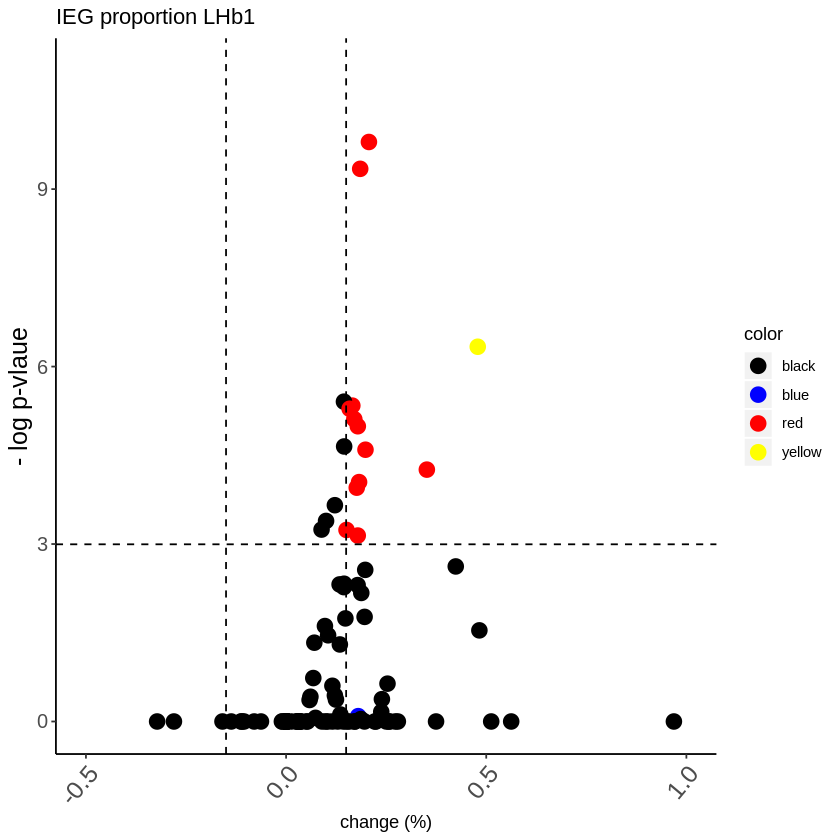

In [20]:
#LHb1, expression
color<- vector(mode="numeric", length=0)
MHb<- subset(Cell_number,type=="LHb1")
for(i in 1:dim(MHb)[1]){
    
    if(MHb$gene[i]=="Fos"){color[i]<-"yellow"}

    else if(MHb$gene[i]=="Egr1"){color[i]<-"blue"}      
     else if (MHb$E_p[i] > -log(0.05) & MHb$E_change[i]>0.15 ){color[i]<- "red"}
    else{color[i]<-"black"}
}
MHb$color<-color

ggplot(MHb,aes(x=E_change,y=E_p,color=color))+geom_point(size=4)+ylab("- log p-vlaue")+xlab("change (%)")+scale_color_manual(values=c("black","blue","red","yellow"))+theme(axis.text.x=element_text(size=10,angle = 50, hjust = 1))+ggtitle("IEG proportion LHb1")+
theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=12),axis.text.x=element_text(size=15,angle = 50, hjust = 1),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+xlim(-0.5,1)+ylim(0,11)+ geom_hline(yintercept=-log(0.05), linetype="dashed", color = "black")+ geom_vline(xintercept =c(-0.15,0.15), linetype="dashed",color = "black")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/LHb1_Expression_level_supple60.15_testaxis.pdf",width=10,height=10) # may use +scale_fill_manual(values=c("grey", "black"))
write.xlsx2(MHb,file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/LHb1_Expression_level_supple6.xlsx")

Warning message:
“Removed 30 rows containing missing values (geom_point).”Warning message:
“Removed 30 rows containing missing values (geom_point).”

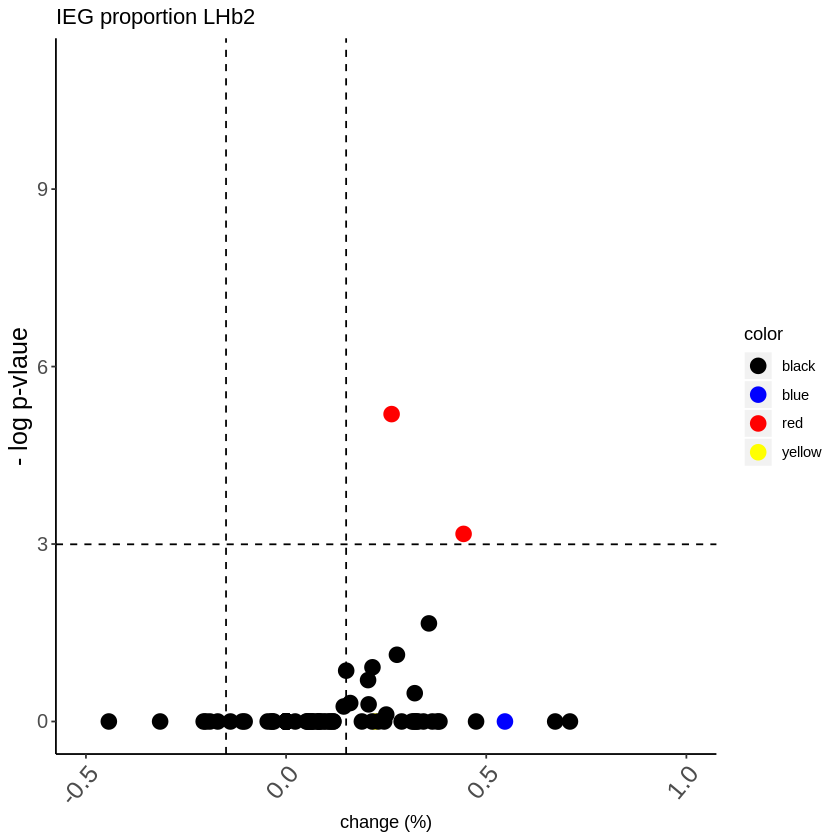

In [21]:
#LHb2, expression, re[peat for others
color<- vector(mode="numeric", length=0)
MHb<- subset(Cell_number,type=="LHb2")
for(i in 1:dim(MHb)[1]){
    
    if(MHb$gene[i]=="Fos"){color[i]<-"yellow"}
    else if(MHb$gene[i]=="Egr1"){color[i]<-"blue"}      
     else if (MHb$E_p[i] > -log(0.05) & MHb$E_change[i]>0.15 ){color[i]<- "red"}
    else{color[i]<-"black"}
}
MHb$color<-color

ggplot(MHb,aes(x=E_change,y=E_p,color=color))+geom_point(size=4)+ylab("- log p-vlaue")+xlab("change (%)")+scale_color_manual(values=c("black","blue","red","yellow"))+theme(axis.text.x=element_text(size=10,angle = 50, hjust = 1))+ggtitle("IEG proportion LHb2")+
theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=12),axis.text.x=element_text(size=15,angle = 50, hjust = 1),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+xlim(-0.5,1)+ylim(0,11)+ geom_hline(yintercept=-log(0.05), linetype="dashed", color = "black")+ geom_vline(xintercept =c(-0.15,0.15), linetype="dashed",color = "black")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/LHb2_Expression_level_supple60.15_test_axis.pdf",width=10,height=10) # may use +scale_fill_manual(values=c("grey", "black"))
write.xlsx2(MHb,file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/LHb2_Expression_level_supple6.xlsx")